In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
from tqdm import tqdm
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [3]:
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9),
 CpuDevice(id=10),
 CpuDevice(id=11),
 CpuDevice(id=12),
 CpuDevice(id=13),
 CpuDevice(id=14),
 CpuDevice(id=15)]

In [4]:
from sklearn.cluster import MiniBatchKMeans
from netneurotools import cluster
from joblib import Parallel, delayed

In [5]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting, predictive_power
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [6]:
cwd = os.getcwd()
head = Path(cwd).parents[2]
path_data = os.path.join(head, 'saved_data/')

In [7]:
path_figures = os.path.join(head, 'figures/emp/pepr_April2024')
path_figures

'/home/anastasios/Marseille/projects/brain_screening/figures/emp/pepr_April2024'

In [8]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [9]:
ages = output_dict["ages"]

In [10]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [11]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = numpy.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered[p] = bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1)

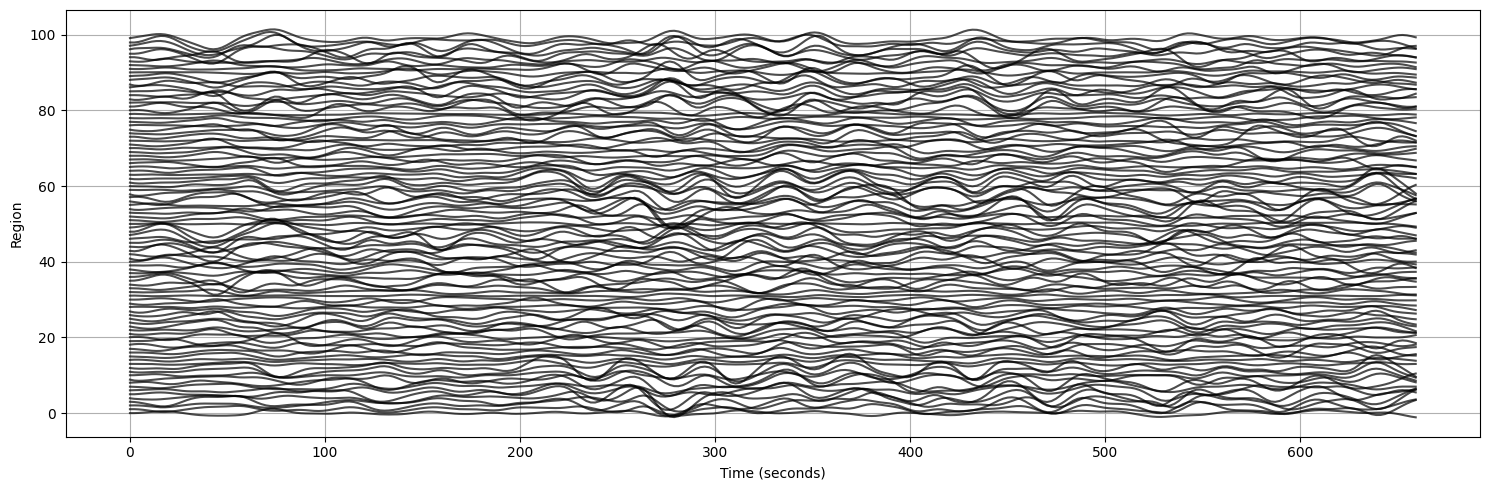

In [12]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

## Leida Cen SC

## step 1: transform the data

In [13]:
v1s = np.load(os.path.join(head, 'intermediate_files/v1s.npy'))

## step2: cluster into recurrent objects

In [14]:
part = getdata.split_test_retest()
xtest = v1s[:,:part,:]
xretest = v1s[:,-part:,:]

In [15]:
from tqdm import tqdm

## fingerprinting for increasing number of states

In [18]:
def test_fp_LeidaCenSC(k_evecs, xretest, n_states, num_permutations=1000):
    trlab = est.predict(k_evecs, n_states)
    telab = est.predict_on_unseen(xretest)
    trlab  = trlab.reshape(n_participants,-1)
    telab  = telab.reshape(n_participants,-1)
    fp = fingerprinting.Fingerprinting()
    fp.fit(trlab, telab)
    Xor, yor = fp.transform(trlab, telab)
    permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=num_permutations)
    diff = fp.intrasim.mean() - fp.intersim.mean()
    return diff

In [24]:
np.r_[3:63:3]

Array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54, 57, 60], dtype=int32)

In [26]:
seeds = [0, 42]
n_states_list = np.r_[3:63:3]
diffs = []
for _,seed in enumerate(tqdm(seeds)):
    d = []
    est = clustering.LeidaCenSC(n_states=None, n_init_clusters=50, seed=42)
    est.fit(xtest)
    k_evecs = est.transform(xtest)
    for i,n_states in enumerate(n_states_list): 
        diff = test_fp_LeidaCenSC(xtest, xretest, int(n_states), n_init_clusters=100, random_state=seed)
        d.append(diff)
    diffs.append(d)
diffs =np.asarray(diffs)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [05:43<00:00, 171.84s/it]


Text(0, 0.5, '$intrasim-intersim$')

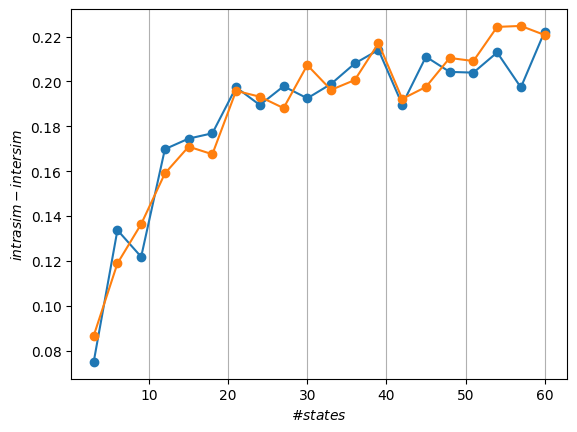

In [35]:
plot(n_states_list, diffs.T, '-o')
grid(axis='x')
xlabel('$\# states$')
ylabel('$intrasim-intersim$')

### fingerprinting for `n_states``

In [ ]:
# wait for optimal number of states to be 8 (a bit stupid i guess)
n_states=None; n_init_clusters=50; 
while n_states != 5:
    est = clustering.LeidaCenSC(n_states=None, n_init_clusters=n_init_clusters)
    est.fit(xtest)
    k_evecs = est.transform(xtest)
    n_states = est.n_states
telab = est.predict(k_evecs)

In [ ]:
fp = fingerprinting.Fingerprinting()

In [ ]:
retelab = est.predict_on_unseen(xretest)

## step3: fingerprinting

In [ ]:
X = telab.reshape(n_participants, -1)
y = retelab.reshape(n_participants, -1)

In [ ]:
fp = fingerprinting.Fingerprinting()
fp.fit(X, y)

Fingerprinting()

In [ ]:
teor, reteor = fp.transform(X, y)

In [ ]:
permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2832.27it/s]


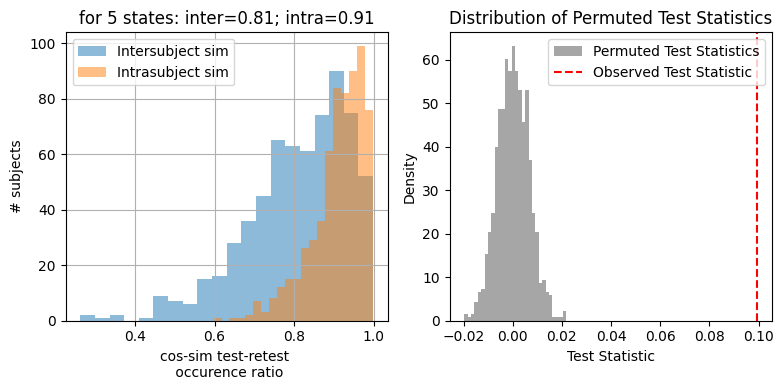

In [ ]:
figure(figsize=(8,4))
subplot(121)
hist(fp.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(fp.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
title(f'for {fp.n_states} states: inter={fp.intersim.mean():0.2f}; intra={fp.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permst, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=obsst, color='red', linestyle='--', label='Observed Test Statistic')
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
# savefig(os.path.join(path_figures, 'fp_LeidaCenSC.png'), dpi=250, bbox_inches='tight')

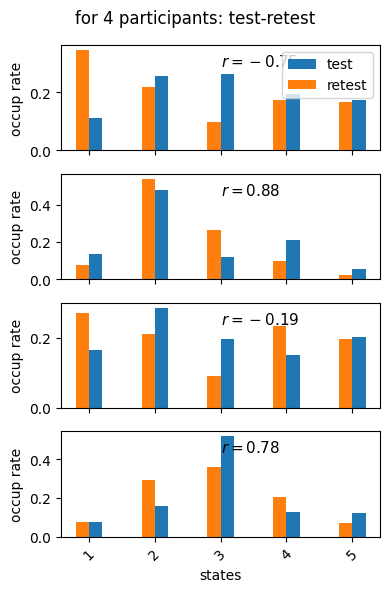

In [ ]:
vor_corcoefs = np.zeros((n_participants))
for p in range(n_participants):
    vor_corcoefs = vor_corcoefs.at[p].set(np.corrcoef(fp.X_[p,:], fp.y_[p,:])[0,1])
x = np.arange(fp.n_states)
width=0.2
f, ax = subplots(4,1,#4 subjects
                     sharex='col', sharey='row', figsize=(4,6))
for p in range(4): 
    ax[p].bar(x+width/2, fp.X_[p,:], width=width, label='test')
    ax[p].bar(x-width/2, fp.y_[p,:], width=width, label='retest')
    ax[p].set_xticks(x,x+1, rotation=45)
    ax[p].annotate(rf'$r={vor_corcoefs[p].round(3):0.02f}$', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=11)
    ax[-1].set_xlabel('states')
    ax[p].set_ylabel('occup rate')
ax[0].legend()
f.suptitle('for 4 participants: test-retest')
tight_layout();
# savefig(os.path.join(path_figures, 'fp_cor_LeidaCenSC.png'), dpi=250, bbox_inches='tight')

## step4: predictive power

### fingerprinting for `n_states``

In [14]:
def test_pp_LeidaCenSC(est, k_evecs, xtest, n_states, ages, train_idx, test_idx):
    trlab = est.predict(k_evecs, n_states)
    telab = est.predict_on_unseen(xtest)
    trlab  = trlab.reshape(train_idx.size,-1)
    telab  = telab.reshape(test_idx.size,-1)
    fp = fingerprinting.Fingerprinting()
    fp.fit(trlab, telab)
    tror, teor = fp.transform(trlab, telab)
    pp = predictive_power.Predict()
    y = ages[train_idx]
    pp.fit(tror, y)
    predictors, r_values, p_values = pp.predict(teor, ages[test_idx])
    return tror, predictors, r_values, p_values

In [15]:
train_idx, test_idx = getdata.split_train_test()

In [16]:
xtrain = v1s[train_idx].copy()
xtest = v1s[test_idx].copy()
xtrain.shape, xtest.shape

((516, 294, 100), (132, 294, 100))

In [17]:
import gc

In [18]:
seeds = [0,42]
r_values = []
p_values = []
n_states_list = np.r_[3:93:3]
diffs = []
for seed in seeds:
    rs = []
    ps = []
    est = clustering.LeidaCenSC(n_states=None, n_init_clusters=294, seed=seed)
    est.fit(xtrain)
    k_evecs = est.transform(xtrain)
    for i,n_states in enumerate(tqdm(n_states_list)): 
        _, _, r, p = test_pp_LeidaCenSC(est, k_evecs, xtest, int(n_states), ages, train_idx, test_idx)
        rs.append(r)
        ps.append(p)
        gc.collect()
    r_values.append(rs)
    p_values.append(ps)
r_values =np.asarray(r_values)
p_values =np.asarray(p_values)

100%|██████████| 30/30 [06:52<00:00, 13.77s/it]


Text(0, 0.5, '$r-values$')

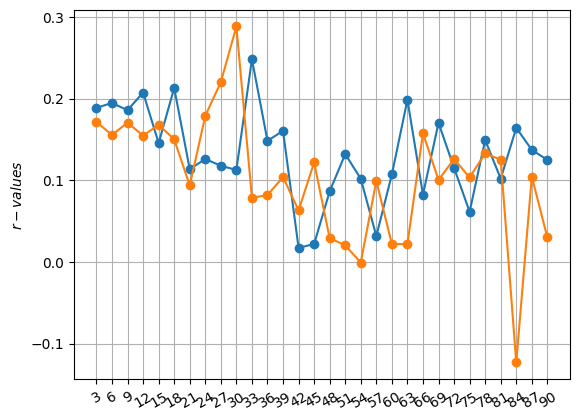

In [22]:
plot(n_states_list, r_values.T, '-o')
xticks(n_states_list, rotation = 30)
grid()
ylabel('$r-values$')

### Predictive power

In [ ]:
# wait for optimal number of states to be the desired one (a bit stupid i guess)
n_states=None
# while n_states != 5:
est = clustering.LeidaCenSC(n_states=None, n_init_clusters=50, seed=99)
est.fit(xtrain)
k_evecs = est.transform(xtrain)
n_states = est.n_states

In [ ]:
n_states_list = est.n_states_calculated
n_states_list

Array([ 3, 10, 14, 12], dtype=int32)

In [ ]:
r_values = []
p_values = []
for i, n_states in enumerate(tqdm(n_states_list)): 
    print(int(n_states))
    _, _, r, p = test_pp(k_evecs, xtest, int(n_states), ages, train_idx, test_idx)
    r_values.append(r)
    p_values.append(p)
r_values =np.asarray(r_values)
p_values =np.asarray(p_values)

  0%|          | 0/4 [00:00<?, ?it/s]

3


 25%|██▌       | 1/4 [00:03<00:09,  3.23s/it]

10


 50%|█████     | 2/4 [00:07<00:08,  4.10s/it]

14


 75%|███████▌  | 3/4 [00:14<00:05,  5.17s/it]

12


100%|██████████| 4/4 [00:20<00:00,  5.04s/it]


In [ ]:
r_values, p_values

(Array([0.10705181, 0.16964018, 0.21279077, 0.1181698 ], dtype=float32),
 Array([0.221803  , 0.05182334, 0.0142995 , 0.17718029], dtype=float32))

In [ ]:
tror, predictors, r, p = test_pp(k_evecs, xtest, int(n_states_list[int(p_values.argmin())]), ages, train_idx, test_idx)

(Text(0, 0.5, 'true age'), Text(0.5, 0, 'predicted age'))

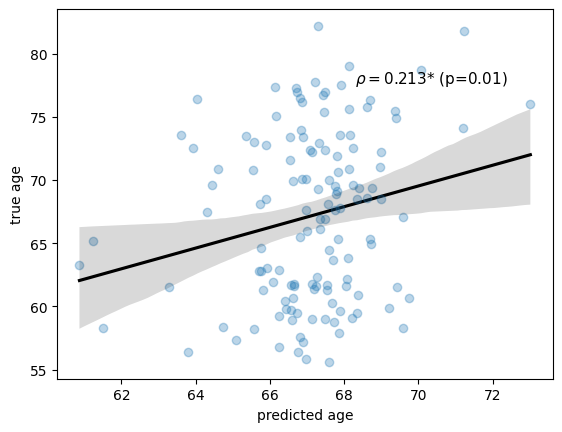

In [ ]:
y = predictors
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')
# savefig(os.path.join(path_figures, 'LeidaCenSC/pp_LeidaCenSC_morestates.png'), dpi=250, bbox_inches='tight')

In [ ]:
path_figures

'/home/anastasios/Marseille/projects/brain_screening/figures/emp/pepr_April2024'

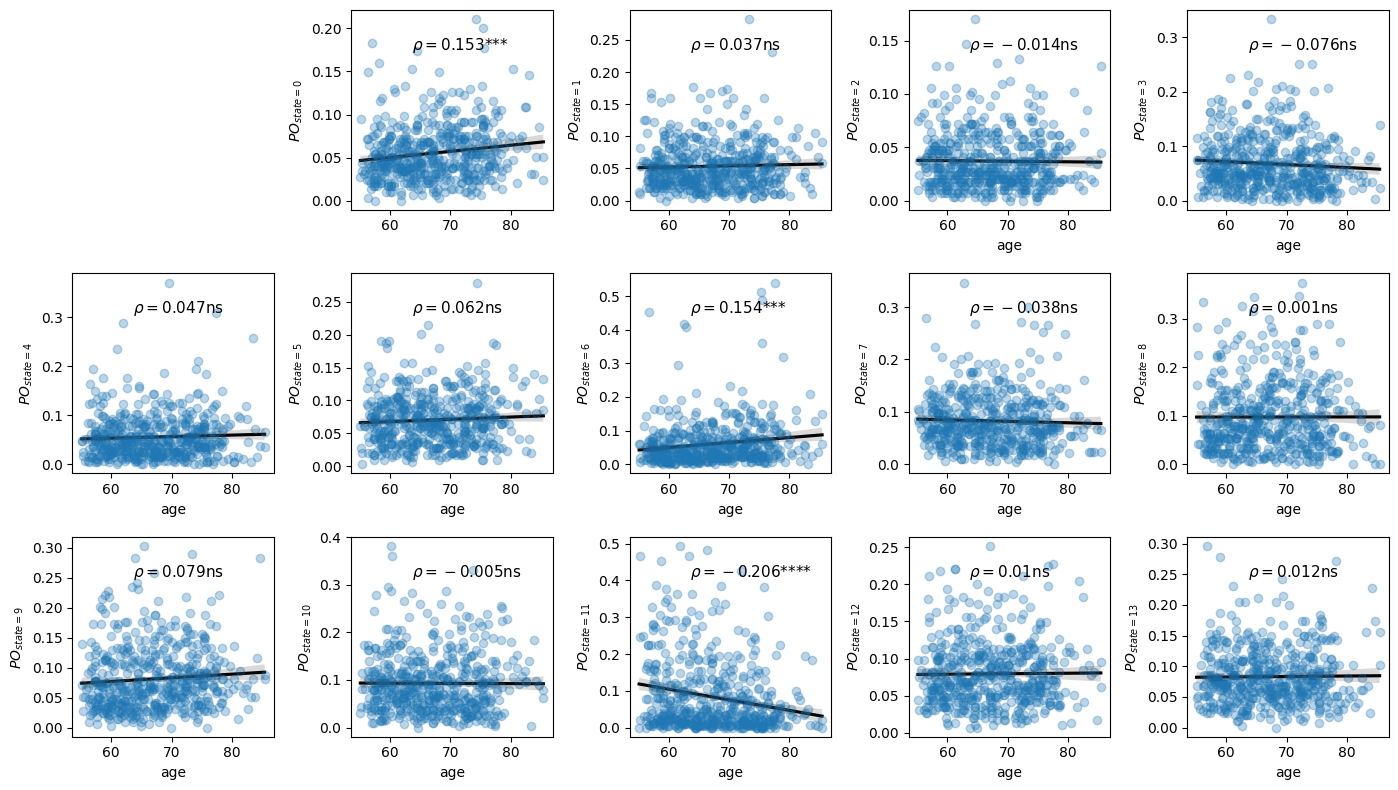

In [ ]:
b =  ages[train_idx]
figure(figsize=(14,8))
for i in range(14):
    y = tror[:,i]
    subplot(3,5,i+2)
    sns.regplot(x=b, y=y,
                line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
    slope,_,r_value,p_value,_ = scipy.stats.linregress(x=b, y=y)
    annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)}',
            xy=(0.3, 0.8), xycoords='axes fraction', fontsize=11)
    ylabel(f'$PO_{{state={i}}}$')
    if i>1:
        xlabel('age')
tight_layout()
# savefig(os.path.join(path_figures, 'LeidaCenSC/pp_perstate_LeidaCenSC_morestates.png'), dpi=250, bbox_inches='tight')
show()